In [17]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import linregress
from pathlib import Path

in_csv = "atom_counts.csv"
out_csv = "atom_counts_dedup.csv"

df = pd.read_csv(in_csv)

In [2]:
# Count duplicates, clean up data
n_before = len(df)
n_unique_before = df["pdb_code"].nunique()

# Keep first of each duplicate
df_dedup = df.drop_duplicates(subset=["pdb_code"], keep="first").copy()

n_after = len(df_dedup)

print(f"Rows before: {n_before}")
print(f"Rows after : {n_after}")

# Only save if something changed
if n_after < n_before:
    df_dedup.to_csv(out_csv, index=False)
    print(f"Duplicates found, saved deduplicated file to '{out_csv}'")
else:
    print("No duplicates found, no new file saved")

Rows before: 8715
Rows after : 8715
No duplicates found, no new file saved


In [4]:
RAW_CSV = Path("atom_counts.csv")
CLEAN_CSV = Path("atom_counts_dedup.csv")

if CLEAN_CSV.exists():
    print(f"Using cleaned file: {CLEAN_CSV}")
    df = pd.read_csv(CLEAN_CSV)
else:
    print(f"Cleaned file not found, using raw file: {RAW_CSV}")
    df = pd.read_csv(RAW_CSV)

print(f"Loaded {len(df)} rows")
df.head()


Cleaned file not found, using raw file: atom_counts.csv
Loaded 8715 rows


,pdb_code,phase,gro,protein_atoms,protein_heavy_atoms,n_ca,n_residues,n_chains,total_atoms
0,1a28,4,/work001/misc/bekker/kakC/dynamicsdb/raw/4/1a2...,4144,2040,251,253,1,4197
1,1a53,4,/work001/misc/bekker/kakC/dynamicsdb/raw/4/1a5...,4083,2003,247,247,1,4113
2,1a8a,4,/work001/misc/bekker/kakC/dynamicsdb/raw/4/1a8...,5013,2507,318,319,1,5050
3,1add,4,/work001/misc/bekker/kakC/dynamicsdb/raw/4/1ad...,5548,2792,349,349,1,5583
4,1aj2,4,/work001/misc/bekker/kakC/dynamicsdb/raw/4/1aj...,4304,2147,282,282,1,4333


In [5]:
#Check to make sure there are no 0 values
df = df[
    (df["protein_heavy_atoms"] > 0) &
    (df["n_residues"] > 0) &
    (df["n_ca"] > 0)
].copy()

print(f"Remaining valid proteins: {len(df)}")


Remaining valid proteins: 8715


In [12]:
summary = df[[
    "protein_heavy_atoms",
    "n_ca",
    "n_residues",
    "n_chains",
]].describe()

#pd.options.display.float_format = "{: .0f}".format
summary.style.format("{:.0f}")

,protein_heavy_atoms,n_ca,n_residues,n_chains
count,8715,8715,8715,8715
mean,1863,235,236,1
std,1111,141,141,0
min,443,57,58,1
25%,1088,139,140,1
50%,1629,207,208,1
75%,2327,290,292,1
max,23550,3099,3099,1


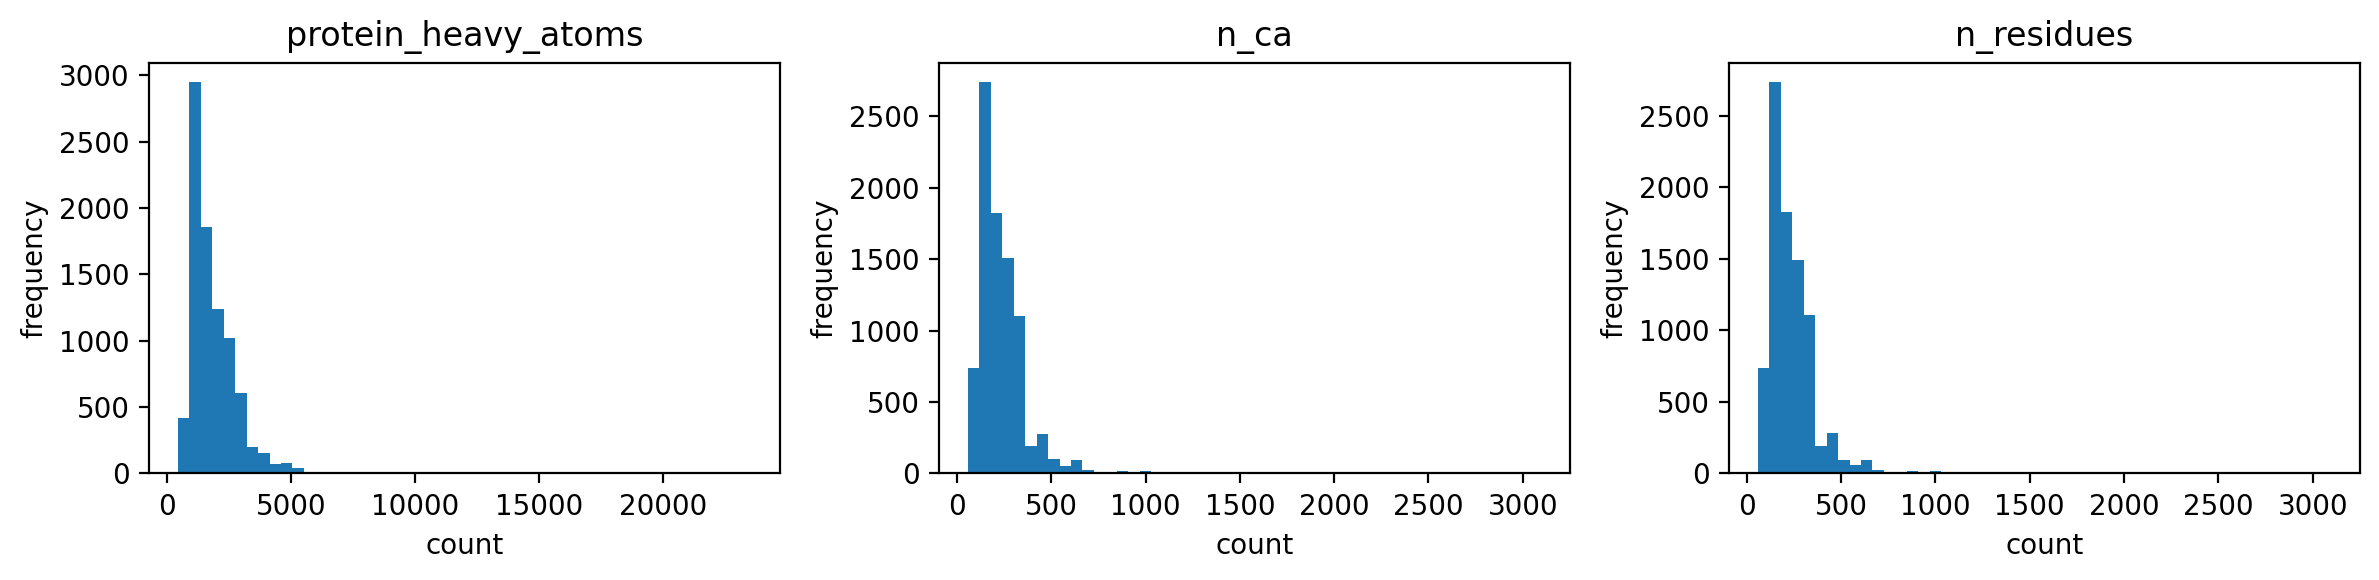

In [19]:
plt.rcParams["figure.dpi"] = 200
fig, axes = plt.subplots(1, 3, figsize=(12, 3))

for ax, col in zip(
    axes,
    ["protein_heavy_atoms", "n_ca", "n_residues"]
):
    ax.hist(df[col], bins=50)
    ax.set_title(col)
    ax.set_xlabel("count")
    ax.set_ylabel("frequency")

plt.tight_layout()
plt.show()

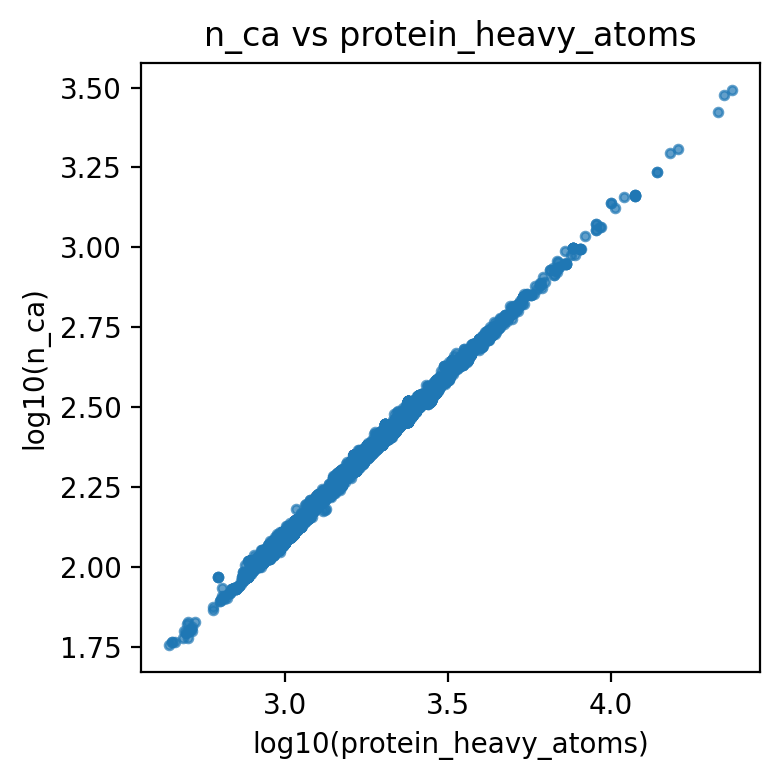

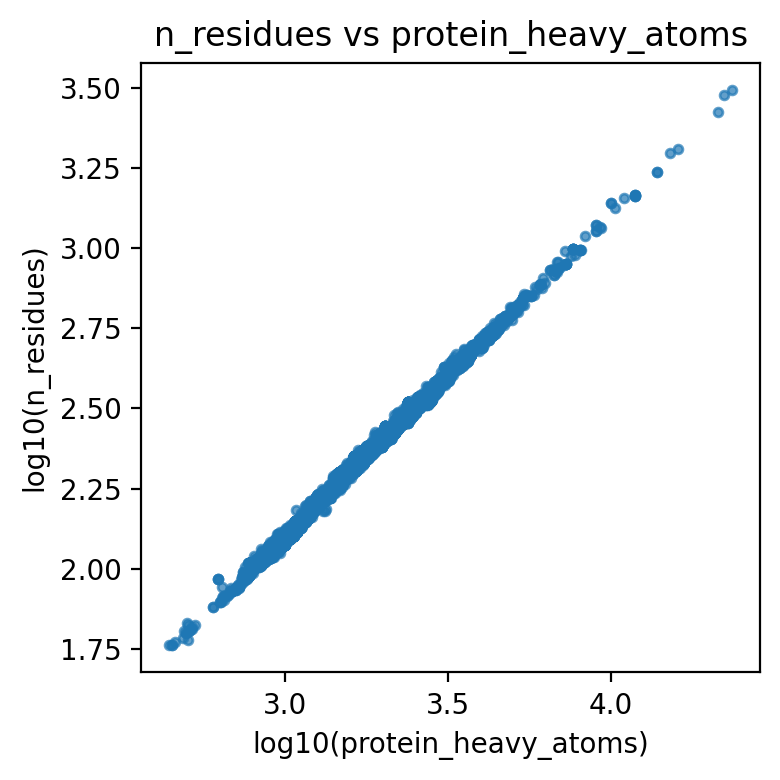

In [20]:
pairs = [
    ("protein_heavy_atoms", "n_ca"),
    ("protein_heavy_atoms", "n_residues"),
]

for xcol, ycol in pairs:
    plt.figure(figsize=(4, 4))
    plt.scatter(
        np.log10(df[xcol]),
        np.log10(df[ycol]),
        s=10,
        alpha=0.7,
    )
    plt.xlabel(f"log10({xcol})")
    plt.ylabel(f"log10({ycol})")
    plt.title(f"{ycol} vs {xcol}")
    plt.tight_layout()
    plt.show()

In [21]:
def fit_scaling(x, y):
    res = linregress(np.log(x), np.log(y))
    return res.slope, res.rvalue**2

for xcol, ycol in pairs:
    alpha, r2 = fit_scaling(df[xcol], df[ycol])
    print(f"{ycol} ~ {xcol}^α : α = {alpha:.3f}, R² = {r2:.3f}")

n_ca ~ protein_heavy_atoms^α : α = 1.004, R² = 0.994
n_residues ~ protein_heavy_atoms^α : α = 1.000, R² = 0.995
